## School project - 5DEEP
The following notebook has been created for a school project on audio classification. The subject and the questions are available in the appendix.

The group members who participated in this project are:
- AMIMI Lamine
- BEZIN Théo
- LECOMTE Alexis
- PAWLOWSKI Maxence

### Main index
1. Data analysis
2. Data preprocessing
3. Basic ANN model
4. The CNN model
5. The model competition
6. **Data augmentation (you are here)**
7. _Appendix_

# 6 - Data augmentation
Data augmentation is a technique used to increase the diversity of a dataset by modifying existing samples. In this notebook, we will discuss augmentation methods and try this new dataset on two of our previous models.

### Index
<ol type="A">
  <li>Notebook initialization</li>
  <li>Augmentation techniques</li>
  <li>Processing the augmented dataset</li>
  <li>Data preparation</li>
  <li>Testing the augmented data : The ANN</li>
  <li>Testing the augmented data : The CNN</li>
  <li>Conclusion of the data augmentation</li>
</ol>

## A - Notebook initialization
### A.1 - Imports

In [2]:
# OS and filesystem
import os
import sys
from pathlib import Path
from timeit import default_timer as timer
from datetime import timedelta

# Math
import numpy

# Data
import pandas
from matplotlib import pyplot

# Sound processing
import librosa
import librosa.display
import soundfile
import audiomentations

# Model processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Console output
from colorama import Style
from tqdm.notebook import tqdm

# Misc.
import typing

# Local files
sys.path.append(os.path.join(os.pardir, os.pardir))
import helpers

### A.2 - Package initialization

In [3]:
pyplot.style.use("ggplot")  # Set the matplotlib style
keras.backend.set_image_data_format("channels_last")  # Define the last value of the model input shape as the color channel

### A.3 - Constants

In [4]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = (PARENT_FOLDER / ".." / ".." / "data").resolve()
URBAN_DATASET_FOLDER = DATA_FOLDER / "UrbanSound8K"
MODELS_FOLDER = (PARENT_FOLDER / ".." / ".." / "models").resolve()
TEMP_FOLDER = (PARENT_FOLDER / ".." / ".." / "temp").resolve()

# Dataset
CLASSES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]
N_MELS = 128

# Misc.
RANDOM_STATE = 2077

### A.4 - Dataset loading

In [5]:
data = pandas.read_csv(URBAN_DATASET_FOLDER / "metadata" / "UrbanSound8K.csv")
print(f"{data.shape[0]} rows, {data.shape[1]} columns")
data.head(n=5)

8732 rows, 8 columns


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## B - Augmentation techniques
We augment a dataset by applying small transformations to the existing data. A data sample resulting from the augmentation transformations has the same class as the original sample, but the model perceives them as two different samples. When working with audio data, there are two main ways to augment the data. We can transform the raw audio samples, or the resulting spectrogram.

### B.1 - Raw audio augmentation
There are many techniques to augment raw audio data and most of them are implemented in the `audiomentations` package. We will only describe the transformation functions we used, the [documentation](https://iver56.github.io/audiomentations/) contains more information. You can also listen to the effects of the transformations on [this website](https://phrasenmaeher-audio-transformat-visualize-transformation-5s1n4t.streamlit.app/).

The pipeline can start with four different composers: `Compose`, `SpecCompose`, `OneOf` and `SomeOf`. We chose the `SomeOf` composer with a number of transformations in the range $[1, all]$.
1. **[AddGaussianNoise](https://iver56.github.io/audiomentations/waveform_transforms/add_gaussian_noise/):** This transformation adds noise (random amplitude data) to the audio file. It produces an effect similar to that of a poor quality microphone.
2. **[TimeStretch](https://iver56.github.io/audiomentations/waveform_transforms/time_stretch/):** It changes the speed of the audio without changing the pitch.
3. **[PitchShift](https://iver56.github.io/audiomentations/waveform_transforms/pitch_shift/):** Applies a pitch variation to the signal without changing the tempo.
4. **[Shift](https://iver56.github.io/audiomentations/waveform_transforms/shift/):** Shifts the samples forward or backward. Most of our dataset is composed of sounds in which the order doesn't really matter, unlike a human speaking. In this situation we can set the `rollover` parameter to true without affecting the understanding of the audio file.

In [8]:
augment_pipeline = audiomentations.SomeOf(num_transforms=(1, None), transforms=[
    audiomentations.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    audiomentations.TimeStretch(min_rate=0.8, max_rate=1.25, leave_length_unchanged=True, p=0.5),
    audiomentations.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    audiomentations.Shift(min_fraction=-0.5, max_fraction=0.5, rollover=True, fade=False, p=0.5)
])

### B.2 - Spectrogram augmentation
The second augmentation technique consists in applying a series of masks on a Mel spectrogram.

- Frequency masking is achieved by randomly overwriting lines with null data.
- Time masking is done in the same way as frequency masking, but this time by deleting columns.

For now, we only use the raw data augmentation. It may be interesting in the future to compare model performance between raw augmentation, spectrogram augmentation, and both augmentations at the same time.

## C - Processing the augmented dataset
It is time to apply our augmentation pipeline to the dataset. This will produce a second dataset of the same shape, doubling our data count. Each augmented file will be saved on the disk, in a new folder.

In [10]:
def apply_augmentation(df: pandas.DataFrame, pipeline: typing.Any) -> pandas.DataFrame:
    augmented_data = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Augmenting the dataset..."):
        # Load the audio file and augment it
        samples, sampling_rate = helpers.urban_df.load_audio(dataset_folder=URBAN_DATASET_FOLDER, fold=row["fold"], file_name=row["slice_file_name"])
        samples_augmented = pipeline(samples=samples, sample_rate=sampling_rate)

        # Save the audio file
        save_folder = (URBAN_DATASET_FOLDER / "audio_augmented" / f"fold{row['fold']}")
        save_folder.mkdir(parents=True, exist_ok=True)
        soundfile.write(file=(save_folder / row["slice_file_name"]), data=samples_augmented, samplerate=sampling_rate)

        # Append the augmented data to the list
        row_dict = row.to_dict()
        row_dict["augmented"] = True
        augmented_data.append(row_dict)

    return pandas.DataFrame(augmented_data)


augmented_df = apply_augmentation(df=data, pipeline=augment_pipeline)

Augmenting the dataset...:   0%|          | 0/8732 [00:00<?, ?it/s]

/home/spoonoverlord/miniconda3/envs/5DEEP/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)


We merge the original data set with our augmented set. We also added an `augmented` column to keep information about the data that was obtained by augmentation.

In [11]:
data["augmented"] = False
data_augmented = pandas.concat([data, augmented_df])

print(f"{Style.BRIGHT}Initial dataset:{Style.RESET_ALL} {data.shape}")
print(f"{Style.BRIGHT}Augmented dataset:{Style.RESET_ALL} {data_augmented.shape}")

Initial dataset: (8732, 9)
Augmented dataset: (17464, 9)


The processing of the augmentation is quite time-consuming. We save the dataset before feature extraction for later use.

In [12]:
data_augmented.to_csv(URBAN_DATASET_FOLDER / "metadata" / "UrbanSound8K_augmented.csv")

### C.1 - Feature extraction
We need to rerun the feature extraction with the augmented dataset to construct the Mel spectrogram of the new data.

In [13]:
def extract_features(df: pandas.DataFrame, n_mels: int = N_MELS, duration_sec: int = None) -> pandas.DataFrame:
    features_list = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting features..."):
        # Extract features
        class_label = row["class"]
        mel = helpers.audio.make_mel_spectrogram(dataset_folder=URBAN_DATASET_FOLDER, row=row, n_mels=n_mels, duration_sec=duration_sec)
        augmented = row["augmented"]

        # Append to the features list
        features_list.append([class_label, mel, augmented])

    return pandas.DataFrame(features_list, columns=["class", "mel", "augmented"])


features_augmented = extract_features(df=data_augmented, n_mels=N_MELS, duration_sec=4)

Extracting features...:   0%|          | 0/17464 [00:00<?, ?it/s]

We can now plot the Mel spectrogram of one of the augmented data. We can see that the augmented data produces a similar result to the one obtained in the second notebook with the unmodified dataset.

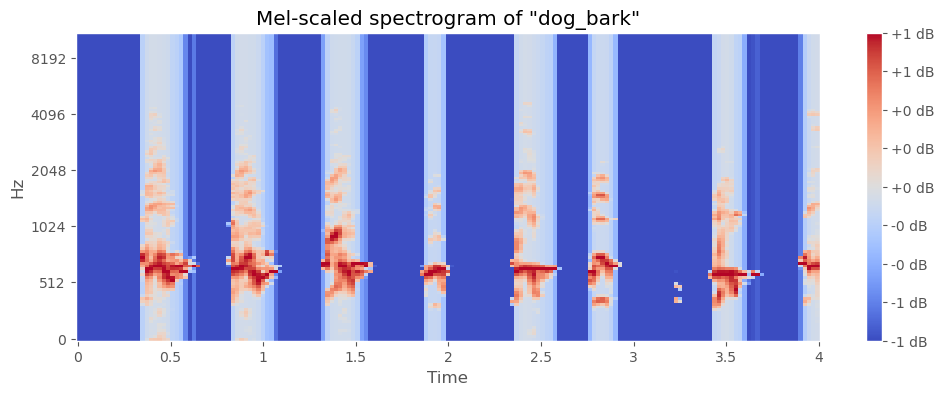

In [15]:
def plot_random_feature(features_df: pandas.DataFrame, fig_size: tuple[float, float] = (12, 4)) -> None:
    random_feature = features_df.sample(n=1).iloc[0]

    fig, ax = pyplot.subplots(figsize=fig_size)
    _ = librosa.display.specshow(random_feature["mel"], x_axis="time", y_axis="mel", ax=ax)
    pyplot.colorbar(ax.get_children()[0], format="%+2.0f dB", ax=ax)
    pyplot.title(f"Mel-scaled spectrogram of \"{random_feature['class']}\"")
    pyplot.show()


plot_random_feature(features_augmented[features_augmented["augmented"] == True])

For exactly the same reason as for data augmentation, we save the augmented features on disk for later use without the need to reprocess them.

In [ ]:
features_augmented_x = numpy.array(features_augmented["mel"].tolist())
features_augmented_y = numpy.array(features_augmented["class"].tolist())

features_augmented.to_csv(DATA_FOLDER / "features-augmented-mel-spectrograms_15-02-23_19-21.csv")  # Save the whole dataset ...
numpy.save(file=str(DATA_FOLDER / "x-augmented-mel-spectrograms_15-02-23_19-21"), arr=features_augmented_x)  # ... and the split [x, y] versions
numpy.save(file=str(DATA_FOLDER / "y-augmented-mel-spectrograms_15-02-23_19-21"), arr=features_augmented_y)

We can then reload the augmented dataset with the following code.

In [7]:
features_augmented_x = numpy.load(file=(str(DATA_FOLDER / "x-augmented-mel-spectrograms_15-02-23_19-21.npy")))
features_augmented_y = numpy.load(file=(str(DATA_FOLDER / "y-augmented-mel-spectrograms_15-02-23_19-21.npy")))

## D - Data preparation
### D.1 - Label encoding

In [9]:
label_encoder = LabelEncoder()
features_augmented_y = keras.utils.to_categorical(y=label_encoder.fit_transform(features_augmented_y), num_classes=len(CLASSES))

### D.2 - Dataset splitting

In [10]:
x_aug_train, x_aug_test, y_aug_train, y_aug_test = train_test_split(features_augmented_x, features_augmented_y, test_size=0.2, random_state=RANDOM_STATE)

print(f"{Style.BRIGHT}Train set >{Style.RESET_ALL} rows: (x={len(x_aug_train)}, y={len(y_aug_train)}) | shape: (x={x_aug_train.shape}, y={y_aug_train.shape})")
print(f"{Style.BRIGHT}Test set >{Style.RESET_ALL} rows: (x={len(x_aug_test)}, y={len(y_aug_test)}) | shape: (x={x_aug_test.shape}, y={y_aug_test.shape})")

Train set > rows: (x=13971, y=13971) | shape: (x=(13971, 128, 173), y=(13971, 10))
Test set > rows: (x=3493, y=3493) | shape: (x=(3493, 128, 173), y=(3493, 10))


### D.3 - Dataset reshape: ANN

In [13]:
x_aug_train_mean = numpy.mean(x_aug_train, axis=1)
x_aug_test_mean = numpy.mean(x_aug_test, axis=1)

### D.4 - Dataset reshape: CNN

In [14]:
num_columns = 173
num_channels = 1

x_aug_train = x_aug_train.reshape(x_aug_train.shape[0], N_MELS, num_columns, num_channels)
x_aug_test = x_aug_test.reshape(x_aug_test.shape[0], N_MELS, num_columns, num_channels)

## E - Testing the augmented data : The ANN
We will now test the augmented dataset on the artificial neural network and compare its performance against the normal dataset.

### E.1 - Training the model

Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1000)              174000    
                                                                 
 dense_8 (Dense)             (None, 750)               750750    
                                                                 
 dense_9 (Dense)             (None, 500)               375500    
                                                                 
 dense_10 (Dense)            (None, 250)               125250    
                                                                 
 dense_11 (Dense)            (None, 100)               25100     
                                                                 
 dense_12 (Dense)            (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 10)                510     

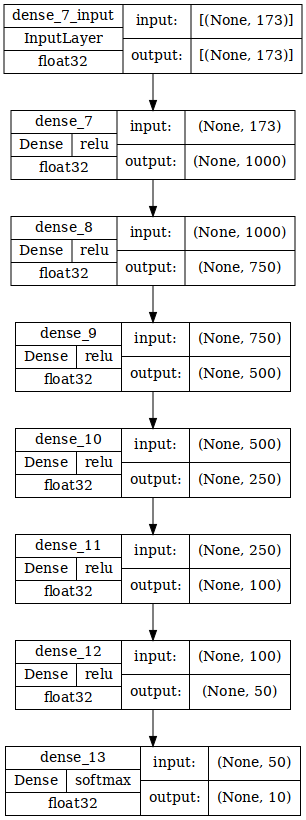

In [16]:
# Model definition
model_ann = keras.models.Sequential(name="ANN", layers=[
    keras.layers.Dense(1000, activation="relu", input_shape=(x_aug_train_mean.shape[1],)),
    keras.layers.Dense(750, activation="relu"),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(len(CLASSES), activation="softmax")
])

# Model summary and plot
model_ann.summary()
keras.utils.plot_model(
    model_ann,
    show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True,
    rankdir="TB", dpi=72,
    to_file=(TEMP_FOLDER / "model_plot_ann.png")
)

In [17]:
adam_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_ann.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])

In [18]:
ckpt_name_base = "1_model-ann-augmented-ckpt"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=str(MODELS_FOLDER / f"{ckpt_name_base}_e-{{epoch:02d}}_vloss-{{val_loss:.2f}}.hdf5"),
    monitor="val_loss",
    save_best_only=True,
    verbose=0
)

In [19]:
batch_size = 128
epochs = 200

start_time = timer()
training_ann = model_ann.fit(x=x_aug_train_mean, y=y_aug_train, validation_split=0.080, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_callback], verbose=1)
print(f"The training of the \"{model_ann.name}\" model took {timedelta(seconds=(timer() - start_time))}.")

Epoch 1/200


2023-02-16 12:08:43.078477: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1bf4d190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-16 12:08:43.078530: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-02-16 12:08:43.241858: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-16 12:08:43.677569: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-16 12:08:43.766256: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 [==============================] - 6s 16ms/step - loss: 1.9764 - accuracy: 0.2537 - val_loss: 1.8538 - val_accuracy: 0.2916
Epoch 2/200
101/101 [==============================] - 1s 14ms/step - loss: 1.7562 - accuracy: 0.3319 - val_loss: 1.7283 - val_accuracy: 0.3497
Epoch 3/200
101/101 [==============================] - 1s 12ms/step - loss: 1.6742 - accuracy: 0.3611 - val_loss: 1.6438 - val_accuracy: 0.3766
Epoch 4/200
101/101 [==============================] - 1s 11ms/step - loss: 1.6078 - accuracy: 0.3927 - val_loss: 1.6039 - val_accuracy: 0.4007
Epoch 5/200
101/101 [==============================] - 1s 11ms/step - loss: 1.5300 - accuracy: 0.4291 - val_loss: 1.5789 - val_accuracy: 0.4088
Epoch 6/200
101/101 [==============================] - 1s 10ms/step - loss: 1.4738 - accuracy: 0.4551 - val_loss: 1.5839 - val_accuracy: 0.4177
Epoch 7/200
101/101 [==============================] - 1s 10ms/step - loss: 1.4313 - accuracy: 0.4751 - val_loss: 1.5414 - val_accuracy: 0.4508
Epoc

In [20]:
history_ann_aug = pandas.DataFrame(training_ann.history)
history_ann_aug.to_csv(MODELS_FOLDER / "histories" / "1_model-ann-augmented_16-02-23_11-37.csv")

In [22]:
model_ann = helpers.ckpts.load_best_model(models_folder=MODELS_FOLDER, base_name=ckpt_name_base)

### E.2 - Model performance

In [23]:
helpers.perfs.print_model_metrics(model=model_ann, x_train=x_aug_train_mean, y_train=y_aug_train, x_test=x_aug_test_mean, y_test=y_aug_test)

Model metrics (ANN):
Training > loss=0.688 | accuracy=76.036
Testing > loss=1.196 | accuracy=63.298


The ANN accuracy score is twice as good with the augmented dataset. The loss score is even lower than with the normal dataset.

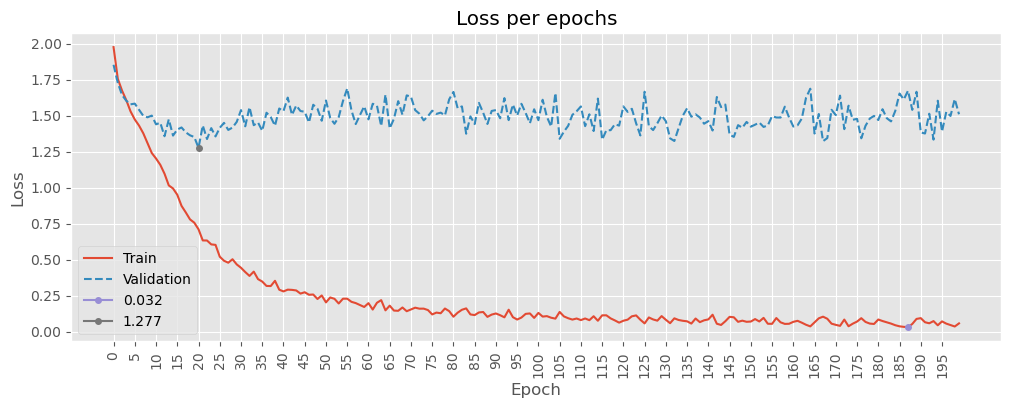

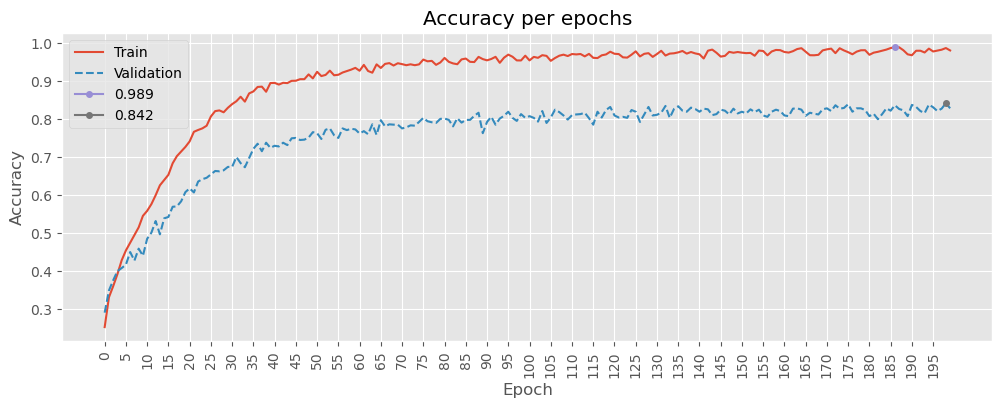

In [24]:
helpers.perfs.plot_loss_curve(history=training_ann.history)
helpers.perfs.plot_accuracy_curve(history=training_ann.history)

Besides the better scores, the model starts to over-fit at the 20th epoch instead of the 10th.

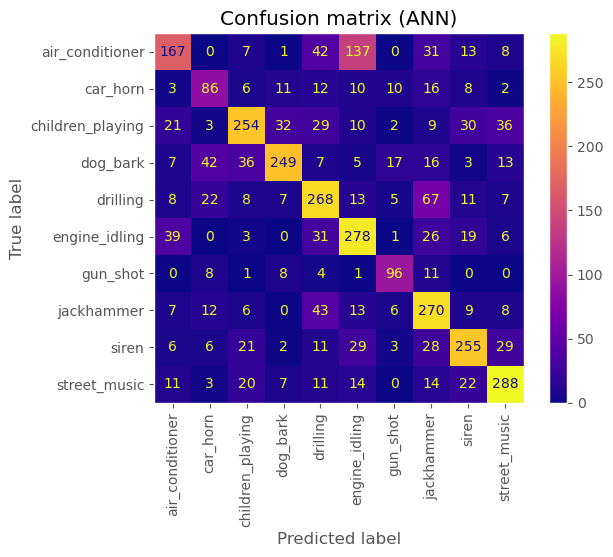

              Class Accuracy
0   air_conditioner  41.13 %
1          car_horn  52.44 %
2  children_playing  59.62 %
3          dog_bark  63.04 %
4          drilling  64.42 %
5     engine_idling  68.98 %
6          gun_shot  74.42 %
7        jackhammer  72.19 %
8             siren  65.38 %
9      street_music  73.85 %


In [25]:
helpers.perfs.plot_confusion_matrix(model=model_ann, x_test=x_aug_test_mean, y_test=y_aug_test, le=label_encoder, classes=CLASSES)

This confusion matrix is a bit less chaotic than with the normal dataset. Nevertheless, we detect the same defects. The class `air_conditioner` is the most confused, but none of the other classes reaches a satisfactory score.

In [26]:
helpers.perfs.print_classification_report(model=model_ann, x_test=x_aug_test_mean, y_test=y_aug_test, le=label_encoder, classes=CLASSES)

Classification report (ANN):
                  precision    recall  f1-score   support

 air_conditioner       0.62      0.41      0.49       406
        car_horn       0.47      0.52      0.50       164
children_playing       0.70      0.60      0.64       426
        dog_bark       0.79      0.63      0.70       395
        drilling       0.59      0.64      0.61       416
   engine_idling       0.55      0.69      0.61       403
        gun_shot       0.69      0.74      0.71       129
      jackhammer       0.55      0.72      0.63       374
           siren       0.69      0.65      0.67       390
    street_music       0.73      0.74      0.73       390

        accuracy                           0.63      3493
       macro avg       0.64      0.64      0.63      3493
    weighted avg       0.64      0.63      0.63      3493



### E.3 - Original vs. augmented dataset
Overall, the ANN model did a better job on the augmented dataset. Despite this, the results of this model are still insufficient for real world use.

## F - Testing the augmented data : The CNN
We will now train the best model from the previous notebook on the new dataset.

### F.1 - Training the model








### F.2 - Model performance
### F.3 - Original vs. augmented dataset

## G - Conclusion of the data augmentation